In [425]:
import pandas as pd
from PIL import Image
import numpy as np
import os 
import re 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, MaxPool2D, Embedding, LSTM, Dropout, TimeDistributed, Reshape, Lambda, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16

In [234]:
with open("descriptions.txt", 'r') as f:
    lines = f.readlines()
all_caption = []
for line in lines:
    all_caption.append(" ".join(line.split()[1:]))

In [235]:
all_caption = pd.read_csv("final_consolidated.csv")

In [236]:
import re
from nltk.stem import WordNetLemmatizer
 
lemma = WordNetLemmatizer()

def preprocess_txt(x):
    try:
        tk_x = x.lower()
        tk_x = re.sub(r'[^\w\s]' ,'', tk_x)
        space_replace_chars = ['?', ':', ',', '"', '[', ']', '~', '*', ';', '!', '?', '(', ')', '{', '}', '@', '$', '#', '.', '-', '/']
        tk_x = tk_x.translate({ord(x): ' ' for x in space_replace_chars})
        non_space_replace_chars = ["'"]
        tk_x = tk_x.translate({ord(x): '' for x in non_space_replace_chars})
        tk_x = ''.join([c if ord(c) < 128 else '' for c in tk_x])
        tk_x = re.sub('\s+', ' ', tk_x).strip()
        tk_x = tk_x.split()
        tk_x = [lemma.lemmatize(token) for token in tk_x]
        tk_x = [token for token in tk_x if token.isalpha()]
        tk_x = ' '.join(tk_x)
        return tk_x.strip().lower()
    except:
        return ""
all_caption['caption'] = all_caption['caption'].apply(preprocess_txt)
all_caption['caption'] = all_caption['caption'].apply( lambda x : '<start> ' + str(x) + ' <end>')
# Choose the top 10000 words from the vocabulary
text_corpus = all_caption['caption'].tolist()
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(text_corpus)
caption_sequences = tokenizer.texts_to_sequences(text_corpus)
caption_vectors = tf.keras.preprocessing.sequence.pad_sequences(caption_sequences, padding='post')

In [237]:
input_seq = np.array([vec[:-1] for vec in caption_vectors])
target_seq = np.array([vec[1:] for vec in caption_vectors])

In [238]:
print(input_seq.shape)
print(target_seq.shape)

(40455, 36)
(40455, 36)


In [8]:
seq_length = input_seq.shape[1]

In [239]:
def preprocess_image(image_src):
    img = tf.io.read_file(image_src)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = tf.cast(img, tf.float32) / 255.0  
    img = (img * 2.0) - 1.0 
    img = img.numpy()
    return img

In [10]:
image_dataset_src = 'D:/Deep Learning Projects/Image captioning - flickr8k/flickr8k/versions/1/Images/'
images_source = []
output_dir = 'D:/Deep Learning Projects/Image captioning - flickr8k/processed_batches/'
os.makedirs(output_dir, exist_ok=True)
for idx, files in enumerate(os.listdir(image_dataset_src), start=1):
    img = preprocess_image(image_dataset_src+files)
    images_source.append(img)
np.save(os.path.join(output_dir, f"image_batch.npy"), np.array(images_source))
del img

In [11]:
file_names = {ele: idx for idx, ele in enumerate(os.listdir(image_dataset_src))}
input_image = []
for line in lines:
    input_image.append(images_source[file_names[line.split()[0].strip()]])

In [422]:
print(len(input_image))
print(input_image[0].shape)

40455
(256, 256, 3)


In [13]:
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# print("Special Tokens:", tokenizer.special_tokens_map)
# start_token = tokenizer.bos_token
# end_token = tokenizer.eos_token   
# input_text = [tokenizer(f"{start_token} {ele} {end_token}")['input_ids'] for ele in text_arr]
# input_text_x = pad_sequences(input_text, maxlen=seq_length, padding='post', truncating='post')
# y_train = pad_sequences(
#     [sentence[1:] for sentence in input_text], 
#     maxlen=seq_length, 
#     padding='post', 
#     truncating='post', 
#     value=0
# )

# input_text_x = np.array(input_text_x)
# y_train = np.array(y_train)
# print(type(input_text_x))
# print(type(image_arr))
# print(type(y_train))

# print(image_arr.shape)
# print(input_text_x.shape)
# print(y_train.shape)


In [428]:
vocab_size = tokenizer.num_words
embedding_dim = 100
lstm_units = 256

In [450]:
# cnn_input = Input(shape=(256, 256, 3))  
# x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(cnn_input)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# cnn_features = Dense(100, activation='relu')(x)


cnn_input = Input(shape=(256, 256, 3))
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=cnn_input)
for layer in vgg_model.layers:
    layer.trainable=False

x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu')(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
cnn_features = Dense(embedding_dim, activation='relu', name='cnn_features')(x)

lstm_input = Input(shape=(seq_length,), name='caption_input')
mask_input = Input(shape=(seq_length,), name='mask_input')

h0 = Dense(lstm_units, activation='tanh', name='initial_h')(cnn_features)
c0 = Dense(lstm_units, activation='tanh', name='initial_c')(cnn_features)


embedding = Embedding(vocab_size, embedding_dim)(lstm_input)


lstm_out = LSTM(units=lstm_units, 
                return_sequences=True, 
                name='decoder_lstm')(embedding, 
                                     initial_state=[h0, c0],
                                     mask=mask_input)
lstm_out = Dropout(0.2)(lstm_out)

output = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_out)
# decode1 = Dense(512, activation='relu')(lstm_out)
# output = Dense(vocab_size, activation='softmax')(decode1)

final_model = Model(inputs=[cnn_input, lstm_input, mask_input], outputs=output)

final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

final_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer_23[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 52,361,972 (199.75 MB)

 Trainable params: 37,647,284 (143.61 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# import tensorflow as tf

# # Load pretrained InceptionV3 model
# pretrained_image_model = tf.keras.applications.InceptionV3(weights='imagenet')
# image_input_tensor = pretrained_image_model.input
# image_model_output = pretrained_image_model.layers[-1].output

# class ImageEncoderModel(tf.keras.Model):
#     def __init__(self):
#         super(ImageEncoderModel, self).__init__()
#         self.cnn_model = tf.keras.Model(inputs=image_input_tensor, outputs=image_model_output)
#         self.dropout = tf.keras.layers.Dropout(0.5)
#         self.fc1 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
#         self.fc2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        
#     def call(self, x, training=False):
#         x = self.cnn_model(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

# class CaptionSequenceModel(tf.keras.Model):
#     def __init__(self, embedding_dim, vocab_size):
#         super(CaptionSequenceModel, self).__init__()
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.lstm1 = tf.keras.layers.LSTM(512, return_sequences=True)
#         self.lstm2 = tf.keras.layers.LSTM(256, return_sequences=False)
#         self.dropout = tf.keras.layers.Dropout(0.5)
        
#     def call(self, x, training=False):
#         # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#         x = self.embedding(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.lstm1(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.lstm2(x)
#         return x

# def build_model(vocab_size, embedding_dim, max_length, training=False):
#     # Define inputs
#     image_inputs = image_input_tensor
#     text_inputs = tf.keras.layers.Input(shape=(max_length,))
    
#     # Process inputs through respective models
#     encoder_model = ImageEncoderModel()(image_inputs, training=training)
#     sequence_model = CaptionSequenceModel(embedding_dim, vocab_size)(text_inputs, training=training)
    
#     # Decoder network
#     decoder1 = tf.keras.layers.add([encoder_model, sequence_model])
#     decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
#     decoder3 = tf.keras.layers.Dense(512, activation='relu')(decoder2)
#     outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder3)
    
#     # Combine image and text model
#     final_model = tf.keras.models.Model(inputs=[image_inputs, text_inputs], outputs=outputs)
#     final_model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     return final_model

# build_model(10000, 100, 36).summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder_mode… │ (None, 256)       │ 24,495,624 │ input_layer_13[0… │
│ (ImageEncoderModel) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_sequence_m… │ (None, 256)       │  3,042,880 │ input_layer_14[0… │
│ (CaptionSequenceMo… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ image_encoder_mo… │
│                     │                   │            │ caption_sequence… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 512)       │    131,584 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 10000)     │  5,130,000 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,865,880 (125.37 MB)

 Trainable params: 32,831,448 (125.24 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [254]:
# batch_size = 5000
# image_arr = []
# batch_num = 1

# for i, image in enumerate(input_image):
#     image_arr.append(image)
#     if (i + 1) % batch_size == 0 or i == len(lines) - 1:
#         np.save(f"D:/Deep Learning Projects/Image captioning - flickr8k/processed_batches/image_batch_{batch_num}.npy", np.array(image_arr, dtype=np.uint8)) 
#         image_arr = []
#         text_arr = []
#         batch_num += 1

# print(f"Saved {batch_num} batches to disk.")

In [430]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [431]:
# import glob
# image_files = sorted(glob.glob("D:/Deep Learning Projects/Image captioning - flickr8k/processed_batches/image_batch_*.npy"))

# image_arr = np.concatenate([np.load(f) for f in image_files], axis=0)

# print(f"Final Image Array Shape: {image_arr.shape}")

In [432]:
input_seq = input_seq.astype("int32") 
target_seq = target_seq.astype("int32")

In [437]:
def create_masks(caption_batch):
    masks = tf.cast(tf.not_equal(caption_batch, 0), tf.float32)
    return masks.numpy()

masks = create_masks(input_seq)

In [440]:
# image_arr_t = tf.convert_to_tensor(image_arr)
# input_seq = tf.convert_to_tensor(input_seq)
# target_seq = tf.convert_to_tensor(target_seq)

In [446]:
from tensorflow.keras.utils import Sequence

class ImageGenerator(Sequence):
    def __init__(self, images, input_sequences, masks, output_sequences, batch_size=32, shuffle=True):
        """
        Custom data generator for images and sequences.
        
        :param images: List of numpy arrays representing images
        :param input_sequences: List of input sequences
        :param output_sequences: List of output sequences
        :param batch_size: Batch size (default: 32)
        :param shuffle: Whether to shuffle data after each epoch (default: True)
        """
        self.images = images
        self.input_sequences = input_sequences
        self.output_sequences = output_sequences
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        """Generates a batch of data."""
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = np.array([self.images[index] for index in batch_indexes])
        batch_input_sequences = np.array(self.input_sequences[batch_indexes])
        batch_masks = np.array(self.masks[batch_indexes])
        batch_output_sequences = np.array(self.output_sequences[batch_indexes])
        
        return (batch_images, batch_input_sequences, batch_masks), batch_output_sequences
    
    def on_epoch_end(self):
        """Shuffle indexes after each epoch if required."""
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [447]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_input, val_input, train_mask, val_mask, train_output, val_output = train_test_split(
    input_image, input_seq, masks, target_seq, test_size=0.2, random_state=42, shuffle=True,
)

In [448]:
trian_imgn = ImageGenerator(train_images, train_input, train_mask, train_output)
val_imgn = ImageGenerator(val_images, val_input, val_mask, val_output)

In [ ]:
final_model.fit(
    trian_imgn,
    validation_data = val_imgn,
    epochs=3,
)

In [313]:
final_model.save("image_to_caption_DS.keras")

### TESTING WITH SAMPLE IMAGES

In [421]:
pred_model = tf.keras.models.load_model("image_to_caption_DS.keras")

In [364]:
resu = final_model.predict([np.expand_dims(input_image[0],axis=0), np.expand_dims(input_seq[0],axis=0)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
Loaded 8091 images for testing.
[[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[

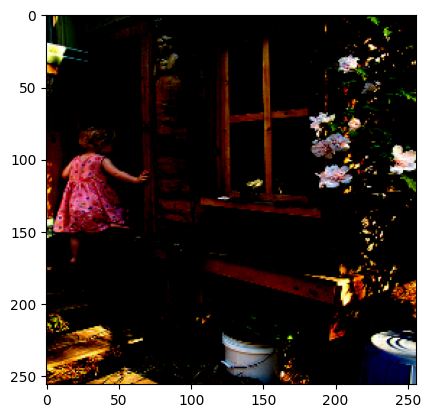

In [324]:
import matplotlib.pyplot as plt
test_image_dir = "D:/Deep Learning Projects/Image captioning - flickr8k/flickr8k/versions/1/Images"
test_images = sorted(os.listdir(test_image_dir))

img = preprocess_image(os.path.join(test_image_dir, test_images[0]))  

# print(image_arr.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)
plt.imshow(img[0])

print(f"Loaded {len(test_images)} images for testing.")

input_test_sequences = np.zeros((1, 36))
input_test_sequences[0, 0] = tokenizer.word_index['<start>']


i=1
while (i<seq_length):
    print(input_test_sequences)
    predictions = final_model.predict([tf.convert_to_tensor(img), input_test_sequences], verbose=0)
    predicted_word = np.argmax(predictions[0, i-1, :])
    # print(np.argmax(genereated_token[0,i]))
    input_test_sequences[0][i] = predicted_word
    input_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(input_test_sequences, padding='post')
    if predicted_word == 4:
        break
    i+=1

for i in list(input_test_sequences[0]):
    if i == 0:
        continue
    print(tokenizer.index_word[i], end=" ")
# generated_captions = [tokenizer.decode(seq, skip_special_tokens=True) for seq in np.argmax(generated_sequences, axis=-1)]

# for img_name, caption in zip(test_images, generated_captions):
#     print(f"{img_name}: {caption}")

(1, 256, 256, 3)
(1, 36)


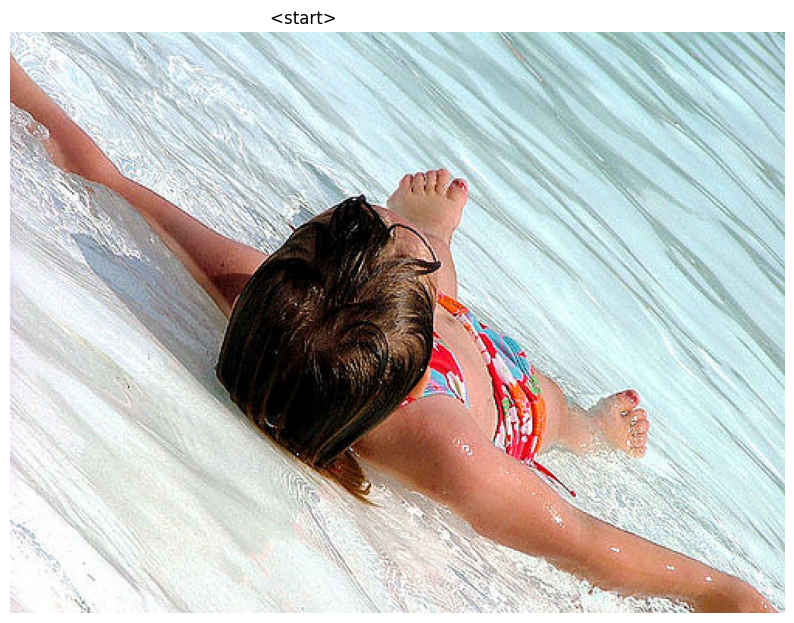

Generated caption: <start>                                    
--------------------------------------------------


In [419]:
# Function to generate a caption for a given image
def generate_caption(image_path, max_length=36):
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    print(img.shape)
    # Start with empty sequence (or start token if you're using one)
    result = [3]
    current_word = 3  # Start token index
    
    # Initialize input sequence with zeros (or start token)
    sequence = np.zeros((1, max_length))
    sequence[0, 0] = current_word  # Set start token
    print(np.array(sequence).shape)
    # Generate words until max length or end token
    for i in range(max_length):
        # Predict next word
        predictions = pred_model.predict([img, sequence], verbose=0)
        # Get the prediction for the current position
        predicted_word = np.argmax(predictions[0, i, :])
        # Break if we predict the end token
        if predicted_word == 4:  # Assuming 0 is padding/end token
            break
            
        # Add the predicted word to our result
        result.append(predicted_word)
        
        # Update the sequence for the next iteration
        if i < max_length - 1:
            sequence[0, i+1] = predicted_word
    
    # Convert word indices to text
    words = [tokenizer.index_word.get(idx, '') for idx in result]
    caption = ' '.join(words)
    return caption

# Test the model on some sample images
def test_model_on_samples(image_paths):
    for image_path in image_paths:
        # Generate caption
        caption = generate_caption(image_path)
        
        # Display image and caption
        img = plt.imread(image_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(caption)
        plt.axis('off')
        plt.show()
        print(f"Generated caption: {caption}")
        print("-" * 50)

# Sample test images
test_image_paths = [
    'D:/Deep Learning Projects/Image captioning - flickr8k/flickr8k/versions/1/Images/667626_18933d713e.jpg'
]

# Run the test
test_model_on_samples(test_image_paths)